In [1]:
import os
import pickle as pkl
path = os.getcwd()

from joblib import Parallel, delayed
from src.est import *
from src.plt_utils import *
from time import perf_counter

SEED = 1000
num_cpus = os.cpu_count() // 2
np.random.seed(SEED)
os.environ['OMP_NUM_THREADS'] = str(num_cpus)
print(f"No. CPUs: {num_cpus}")

SAVE_DATA = True
SAVE_RESULTS = True
LOAD_DATA = False
LOAD_RESULTS = False

folder = "synth_comparison"
data_file = "data_2025-05-24-1900"
results_file = "results_2025-05-24-1900"


No. CPUs: 6


## Arguments

In [2]:
trials = 2

Is = torch.tensor([4,4])
D = len(Is)
I = torch.prod(Is).item()
K = 5
all2ten = (I**2 / (Is.sum()*2+1)).item()
all2mat = (I**2 / (I*2+1))

N = int(3e2)
burn_in = 500

qmin = 1e-6
qmax = 1.
num_itrs = 1000
num_mttkrps = 1000
tol = 1e-7
slide_window = 1000
alpha_factor = 1e0
alpha_weight = 1e0
gamma_factor = 3e-1
gamma_weight = 3e-1
beta = 5e-1
eps = 1e-9
ALPHA_TYPE = "adam"

B = 10
B_max = 100
B_adam = lambda K: int(10 * K * np.log(K) / np.log(2))
INCREASE_B = False
ACCELERATION = True

print(f"Ratio of tensor rank to states: {K/I:.2f}")
print(f"No. total parameters: {I**2}")
print(f"No. low-rank matrix parameters: {2*I+1} * K")
print(f"No. low-rank tensor parameters: {2*Is.sum()+1} * K")
print(f"Ratio of total to matrix: {all2mat:.2f}")
print(f"Ratio of total to tensor: {all2ten:.2f}")
print(f"")
print(f"Matrix rank {int(np.round(all2mat/all2ten * K))} <-> Tensor rank {K}")
print(f"Matrix parameters {(2*I+1) * int(np.round(all2mat/all2ten * K))} <-> Tensor parameters {K * (2*Is.sum()+1)}")


Ratio of tensor rank to states: 0.31
No. total parameters: 256
No. low-rank matrix parameters: 33 * K
No. low-rank tensor parameters: 17 * K
Ratio of total to matrix: 7.76
Ratio of total to tensor: 15.06

Matrix rank 3 <-> Tensor rank 5
Matrix parameters 99 <-> Tensor parameters 85


In [4]:
ratio_range = np.array([.5,1.])
K_ten_range = np.round(ratio_range * K).astype(int)
K_mat_range = np.round(ratio_range * K * all2mat/all2ten).astype(int)
gamma_range = np.logspace(-1,1,3)

ipdc_args_base = {
    "alpha":1e-1,
    "beta":1.,
    "gamma":1.,
    "pmin":qmin,
    "num_itrs":num_itrs,
    "num_inn_itrs":10,
    "tol":tol,
    "inn_tol":tol,
    "verbose":True,
}

sgsadmm_args_base = {
    "beta":1.,
    "pmin":qmin,
    "num_itrs":num_itrs,
    "tol":tol,
    "verbose":True,
}

slrm_args_base = {
    "qmin":qmin,
}

scpdfib_args_base = {
    "qmin":qmin,
    "qmax":qmax,
    "num_itrs": num_mttkrps * int(torch.ceil(I*I/B/Is.min()).item()),
    "tol":tol * 1e-1,
    "slide_window":slide_window,
    "ALPHA_TYPE":ALPHA_TYPE,
    "alpha_factor":alpha_factor,
    "alpha_weight":alpha_weight,
    "gamma_factor":gamma_factor,
    "gamma_weight":gamma_weight,
    "beta":beta,
    "eps":eps,
    # "B":B,
    # "B_max":B_max,
    "INCREASE_B":INCREASE_B,
    "ACCELERATION":ACCELERATION,
}

scpdent_args_base = {
    "qmin":qmin,
    "qmax":qmax,
    # "num_itrs": num_mttkrps * int(torch.ceil(I*I/Is.min()).item() / 10),
    "num_itrs": num_mttkrps * int(torch.ceil(I*I/B/Is.min()).item()),
    # "num_itrs": num_mttkrps * 100,
    "tol":tol * 1e-1,
    "slide_window":slide_window,
    "ALPHA_TYPE":ALPHA_TYPE,
    "alpha_factor":alpha_factor * 1e-1,
    "alpha_weight":alpha_weight * 1e-1,
    "gamma_factor":gamma_factor,
    "gamma_weight":gamma_weight,
    "beta":beta,
    "eps":eps,
    "B":B,
    # "B_max":B_max,
    "INCREASE_B":INCREASE_B,
    "ACCELERATION":ACCELERATION,
}

scpdtraj_args_base = {
    "qmin":qmin,
    "qmax":qmax,
    # "num_itrs": num_mttkrps * int(torch.ceil(I*I/Is.min()).item() / 10),
    "num_itrs": num_mttkrps * int(torch.ceil(I*I/B/Is.min()).item()),
    # "num_itrs": num_mttkrps * 100,
    "tol":tol * 1e-1,
    "slide_window":slide_window,
    "ALPHA_TYPE":ALPHA_TYPE,
    "alpha_factor":alpha_factor * 1e-1,
    "alpha_weight":alpha_weight * 1e-1,
    "gamma_factor":gamma_factor,
    "gamma_weight":gamma_weight,
    "beta":beta,
    "eps":eps,
    "B":B,
    # "B_max":B_max,
    "INCREASE_B":INCREASE_B,
    "ACCELERATION":ACCELERATION,
}

ipdc_args = [ ipdc_args_base | {"K":K} for K in K_mat_range]
ipdc_msgs = [f"K={K}" for K in K_mat_range]

sgsadmm_args = [ sgsadmm_args_base | {"gamma":gamma} for gamma in gamma_range]
sgsadmm_msgs = [f"g={gamma:.1f}" for gamma in gamma_range]

slrm_args = [ slrm_args_base | {"K":K} for K in K_mat_range]
slrm_msgs = [f"K={K}" for K in K_mat_range]

# scpdfib_args = [ scpdfib_args_base | {"K":K} for K in K_ten_range]
scpdfib_args = [ scpdfib_args_base | {"K":K, "B":B_adam(K)} for K in K_ten_range]
scpdfib_msgs = [f"K={K}" for K in K_ten_range]

scpdent_args = [ scpdent_args_base | {"K":K} for K in K_ten_range]
scpdent_msgs = [f"K={K}" for K in K_ten_range]

scpdtraj_args = [ scpdtraj_args_base | {"K":K} for K in K_ten_range]
scpdtraj_msgs = [f"K={K}" for K in K_ten_range]

K_mat_range, K_ten_range


(array([1, 3]), array([2, 5]))

In [5]:
method_names = ["dc","nn","sm","fib","ent","traj"]
method_args = dict(zip( method_names, [ipdc_args,sgsadmm_args,slrm_args,scpdfib_args,scpdent_args,scpdtraj_args] ))
method_msgs = dict(zip( method_names, [ipdc_msgs,sgsadmm_msgs,slrm_msgs,scpdfib_msgs,scpdent_msgs,scpdtraj_msgs] ))

def iPDC_parallel(X,mc,args):
    results = iPDC(mc.P,**args)
    return tuple(results.values())
def sgsadmm_parallel(X,mc,args):
    results = sgsADMM(mc.P,**args)
    return tuple(results.values())
def slrm_parallel(X,mc,args):
    results = SLRM(mc.Q,**args)
    return (results['mc_est'], None, results['cost'])
def fib_parallel(X,mc,args):
    results = SCPD(X, mat2ten(mc.Q,Is), SAMPLING_TYPE="fiber",**args)
    return (results['mc_est'], results['diffs'], results['costs'])
def ent_parallel(X,mc,args):
    results = SCPD(X, mat2ten(mc.Q,Is), SAMPLING_TYPE="entry",**args)
    return (results['mc_est'], results['diffs'], results['costs'])
def traj_parallel(X,mc,args):
    results = SCPD(X, mat2ten(mc.Q,Is), SAMPLING_TYPE="trajectory",**args)
    return (results['mc_est'], results['diffs'], results['costs'])

methods_parallel = {
    "dc":iPDC_parallel,
    "nn":sgsadmm_parallel,
    "sm":slrm_parallel,
    "fib":fib_parallel,
    "ent":ent_parallel,
    "traj":traj_parallel,
}


## Generate data

Data has been saved to synth_comparison/data_2025-05-24-1900


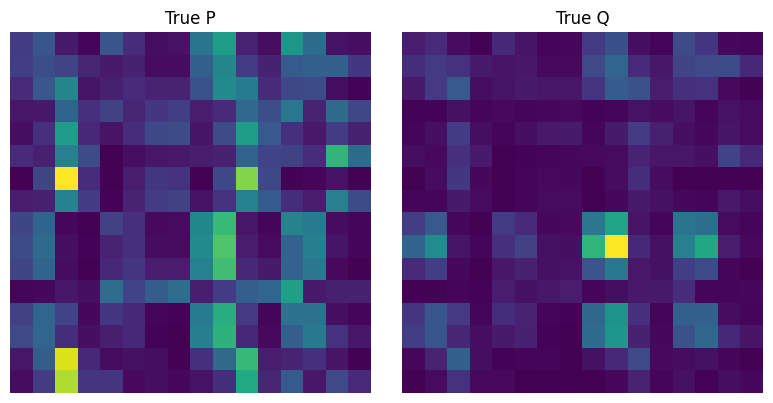

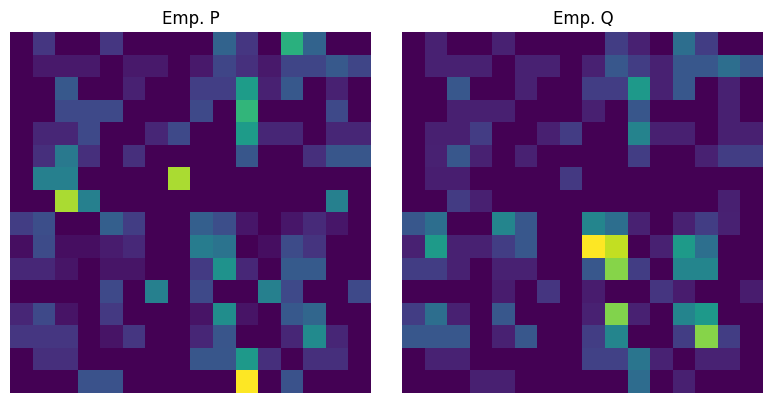

In [6]:
mc = [generate_lowranktensor_model(Is,K) for t in range(trials)]
X = [mc[t].simulate(N+burn_in)[burn_in:] for t in range(trials)]
P_emp = [estimate_empirical_tensor(X[t],Is)[0] for t in range(trials)]
mc_emp = [MarkovChainTensor(P_emp[t]) for t in range(trials)]

if LOAD_DATA:
    data_path = os.path.join(folder,data_file)
    assert os.path.exists(data_path), f"Data file {data_path} does not exist."    
    with open(data_path,"rb") as f:
        loaded_data = pkl.load(f)
        print(f"Data has been loaded from {data_path}.")

    trials = len(mc)
    assert trials==len(mc_emp) and trials==len(X), "Inconsistent number of trials."

    mc = [MarkovChainTensor(loaded_data["P"][t]) for t in range(trials)]
    mc_emp = [MarkovChainTensor(loaded_data["P_emp"][t]) for t in range(trials)]
    X = [loaded_data["X"][t] for t in range(trials)]
if SAVE_DATA:
    if not os.path.exists(folder):
        os.mkdir(folder)

    data = {
        "P":[mc[t].P for t in range(trials)],
        "P_emp":[mc_emp[t].P for t in range(trials)],
        "X":[X[t] for t in range(trials)],
    }

    data_path = os.path.join(folder,data_file)
    with open(data_path,"wb") as f:
        pkl.dump(data,f)
        print(f"Data has been saved to {data_path}")

mc = [MarkovChainMatrix(ten2mat(mc[t].P,I)) for t in range(trials)]
mc_emp = [MarkovChainMatrix(ten2mat(mc_emp[t].P,I)) for t in range(trials)]

t = 0
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); 
ax[0].imshow( mc[t].P )
ax[0].axis('off'); ax[0].set_title("True P")
ax[1].imshow( mc[t].Q )
ax[1].axis('off'); ax[1].set_title("True Q")
fig.tight_layout()

fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); 
ax[0].imshow( mc_emp[t].P )
ax[0].axis('off'); ax[0].set_title("Emp. P")
ax[1].imshow( mc_emp[t].Q )
ax[1].axis('off'); ax[1].set_title("Emp. Q")
fig.tight_layout()


## Estimate Markov chain

In [7]:
results = {n:[[None for _ in range(trials)] for _ in range(len(method_args[n]))] for n in method_names}
mc_est = {n:[[None for _ in range(trials)] for _ in range(len(method_args[n]))] for n in method_names}
diffs_est = {n:[[None for _ in range(trials)] for _ in range(len(method_args[n]))] for n in method_names}
costs_est = {n:[[None for _ in range(trials)] for _ in range(len(method_args[n]))] for n in method_names}

kld_P = {n:[None for i in range(len(method_args[n]))] for n in method_names}
kld_P['emp'] = torch.FloatTensor([kld_err(mc[t].P,laplace_smoothing(mc_emp[t].P,N,1e-9)) for t in range(trials)])
kld_Q = {n:[None for i in range(len(method_args[n]))] for n in method_names}
kld_Q['emp'] = torch.FloatTensor([kld_err(mc[t].Q,laplace_smoothing(mc_emp[t].Q,N,1e-9)) for t in range(trials)])
kld_R = {n:[None for i in range(len(method_args[n]))] for n in method_names}
kld_R['emp'] = torch.FloatTensor([kld_err(mc[t].R,laplace_smoothing(mc_emp[t].R,N,1e-9)) for t in range(trials)])

normfrob_P = {n:[None for i in range(len(method_args[n]))] for n in method_names}
normfrob_P['emp'] = torch.FloatTensor([normfrob_err(mc[t].P,laplace_smoothing(mc_emp[t].P,N,1e-9)) for t in range(trials)])
normfrob_Q = {n:[None for i in range(len(method_args[n]))] for n in method_names}
normfrob_Q['emp'] = torch.FloatTensor([normfrob_err(mc[t].Q,laplace_smoothing(mc_emp[t].Q,N,1e-9)) for t in range(trials)])
normfrob_R = {n:[None for i in range(len(method_args[n]))] for n in method_names}
normfrob_R['emp'] = torch.FloatTensor([normfrob_err(mc[t].R,laplace_smoothing(mc_emp[t].R,N,1e-9)) for t in range(trials)])

norml1_P = {n:[None for i in range(len(method_args[n]))] for n in method_names}
norml1_P['emp'] = torch.FloatTensor([norml1_err(mc[t].P,laplace_smoothing(mc_emp[t].P,N,1e-9)) for t in range(trials)])
norml1_Q = {n:[None for i in range(len(method_args[n]))] for n in method_names}
norml1_Q['emp'] = torch.FloatTensor([norml1_err(mc[t].Q,laplace_smoothing(mc_emp[t].Q,N,1e-9)) for t in range(trials)])
norml1_R = {n:[None for i in range(len(method_args[n]))] for n in method_names}
norml1_R['emp'] = torch.FloatTensor([norml1_err(mc[t].R,laplace_smoothing(mc_emp[t].R,N,1e-9)) for t in range(trials)])


### iPDC - DC algorithm for estimating matrices with approximate rank constraint

In [12]:
n = "dc"

for i in range(len(method_args[n])):
    print(n + " | " + method_msgs[n][i])
    results[n][i] = Parallel(n_jobs=num_cpus)(delayed(methods_parallel[n])( X[t], mc_emp[t], method_args[n][i] ) for t in range(trials))
    mc_est[n][i], diffs_est[n][i], costs_est[n][i] = tuple(zip(*results[n][i]))

    if n in ['fib','ent','traj']:
        mc_est[n][i] = [MarkovChainMatrix(ten2mat(mc_est[n][i][t].P,I)) for t in range(trials)]

    kld_P[n][i] = torch.FloatTensor([kld_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    kld_Q[n][i] = torch.FloatTensor([kld_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    kld_R[n][i] = torch.FloatTensor([kld_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])
    normfrob_P[n][i] = torch.FloatTensor([normfrob_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    normfrob_Q[n][i] = torch.FloatTensor([normfrob_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    normfrob_R[n][i] = torch.FloatTensor([normfrob_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])
    norml1_P[n][i] = torch.FloatTensor([norml1_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    norml1_Q[n][i] = torch.FloatTensor([norml1_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    norml1_R[n][i] = torch.FloatTensor([norml1_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])

    print(f"{n} | {method_msgs[n][i]} | " +
          f"KLD P: {torch.mean(kld_P[n][i]):.3f} | KLD Q: {torch.mean(kld_Q[n][i]):.3f} | Frob P: {torch.mean(normfrob_P[n][i]):.3f}")
    print("")

dc | K=1
Iter. 882 | Diff: 2.25e-02
Iter. 884 | Diff: 4.51e-01
dc | K=1 | KLD P: 37.675 | KLD Q: 1.355 | Frob P: 0.686

dc | K=3
Iter. 831 | Diff: 7.34e-02
Iter. 830 | Diff: 8.12e-01
dc | K=3 | KLD P: 31.961 | KLD Q: 1.205 | Frob P: 0.647



### sgsADMM - ADMM algorithm for estimating matrices with nuclear norm penalty

In [13]:
n = "nn"

for i in range(len(method_args[n])):
    print(n + " | " + method_msgs[n][i])
    results[n][i] = Parallel(n_jobs=num_cpus)(delayed(methods_parallel[n])( X[t], mc_emp[t], method_args[n][i] ) for t in range(trials))
    mc_est[n][i], diffs_est[n][i], costs_est[n][i] = tuple(zip(*results[n][i]))

    if n in ['fib','ent','traj']:
        mc_est[n][i] = [MarkovChainMatrix(ten2mat(mc_est[n][i][t].P,I)) for t in range(trials)]

    kld_P[n][i] = torch.FloatTensor([kld_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    kld_Q[n][i] = torch.FloatTensor([kld_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    kld_R[n][i] = torch.FloatTensor([kld_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])
    normfrob_P[n][i] = torch.FloatTensor([normfrob_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    normfrob_Q[n][i] = torch.FloatTensor([normfrob_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    normfrob_R[n][i] = torch.FloatTensor([normfrob_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])
    norml1_P[n][i] = torch.FloatTensor([norml1_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    norml1_Q[n][i] = torch.FloatTensor([norml1_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    norml1_R[n][i] = torch.FloatTensor([norml1_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])

    print(f"{n} | {method_msgs[n][i]} | " +
          f"KLD P: {torch.mean(kld_P[n][i]):.3f} | KLD Q: {torch.mean(kld_Q[n][i]):.3f} | Frob P: {torch.mean(normfrob_P[n][i]):.3f}")
    print("")


nn | g=0.1
nn | g=0.1 | KLD P: 48.670 | KLD Q: 1.702 | Frob P: 0.664

nn | g=1.0
nn | g=1.0 | KLD P: 46.496 | KLD Q: 1.639 | Frob P: 0.642

nn | g=10.0
nn | g=10.0 | KLD P: 7.081 | KLD Q: 0.371 | Frob P: 0.717



### Spectral low-rank matrix - Spectral thresholding for low-rank joint probability matrix

In [14]:
n = "sm"

for i in range(len(method_args[n])):
    print(n + " | " + method_msgs[n][i])
    results[n][i] = Parallel(n_jobs=num_cpus)(delayed(methods_parallel[n])( X[t], mc_emp[t], method_args[n][i] ) for t in range(trials))
    mc_est[n][i], diffs_est[n][i], costs_est[n][i] = tuple(zip(*results[n][i]))

    if n in ['fib','ent','traj']:
        mc_est[n][i] = [MarkovChainMatrix(ten2mat(mc_est[n][i][t].P,I)) for t in range(trials)]

    kld_P[n][i] = torch.FloatTensor([kld_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    kld_Q[n][i] = torch.FloatTensor([kld_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    kld_R[n][i] = torch.FloatTensor([kld_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])
    normfrob_P[n][i] = torch.FloatTensor([normfrob_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    normfrob_Q[n][i] = torch.FloatTensor([normfrob_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    normfrob_R[n][i] = torch.FloatTensor([normfrob_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])
    norml1_P[n][i] = torch.FloatTensor([norml1_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    norml1_Q[n][i] = torch.FloatTensor([norml1_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    norml1_R[n][i] = torch.FloatTensor([norml1_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])

    print(f"{n} | {method_msgs[n][i]} | " +
          f"KLD P: {torch.mean(kld_P[n][i]):.3f} | KLD Q: {torch.mean(kld_Q[n][i]):.3f} | Frob P: {torch.mean(normfrob_P[n][i]):.3f}")
    print("")


sm | K=1
sm | K=1 | KLD P: 5.933 | KLD Q: 0.313 | Frob P: 0.635

sm | K=3
sm | K=3 | KLD P: 7.194 | KLD Q: 0.329 | Frob P: 0.504



### Fiber-sampling SCPD - Low-rank tensor decomposition via stochastic CPD sampling fibers

In [8]:
n = "fib"

for i in range(len(method_args[n])):
    print(n + " | " + method_msgs[n][i])
    results[n][i] = Parallel(n_jobs=num_cpus)(delayed(methods_parallel[n])( X[t], mc_emp[t], method_args[n][i] ) for t in range(trials))
    mc_est[n][i], diffs_est[n][i], costs_est[n][i] = tuple(zip(*results[n][i]))

    if n in ['fib','ent','traj']:
        mc_est[n][i] = [MarkovChainMatrix(ten2mat(mc_est[n][i][t].P,I)) for t in range(trials)]

    kld_P[n][i] = torch.FloatTensor([kld_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    kld_Q[n][i] = torch.FloatTensor([kld_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    kld_R[n][i] = torch.FloatTensor([kld_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])
    normfrob_P[n][i] = torch.FloatTensor([normfrob_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    normfrob_Q[n][i] = torch.FloatTensor([normfrob_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    normfrob_R[n][i] = torch.FloatTensor([normfrob_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])
    norml1_P[n][i] = torch.FloatTensor([norml1_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    norml1_Q[n][i] = torch.FloatTensor([norml1_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    norml1_R[n][i] = torch.FloatTensor([norml1_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])

    print(f"{n} | {method_msgs[n][i]} | " +
          f"KLD P: {torch.mean(kld_P[n][i]):.3f} | KLD Q: {torch.mean(kld_Q[n][i]):.3f} | Frob P: {torch.mean(normfrob_P[n][i]):.3f}")
    print("")


fib | K=2


MTTKRP: 1/1750 | Cost: 1.429e+00 | Diff: 1.6e-01 | Var: 0.0e+00 | af: 3.5e+00 | aw: 1.0e+00
MTTKRP: 1/1750 | Cost: 1.811e+00 | Diff: 7.4e-02 | Var: 0.0e+00 | af: 3.7e+00 | aw: 1.0e+00
MTTKRP: 298/1750 | Cost: 5.320e-01 | Diff: 2.2e-03 | Var: 2.3e-04 | af: 2.6e-01 | aw: 7.2e-01
MTTKRP: 297/1750 | Cost: 5.041e-01 | Diff: 5.7e-04 | Var: 3.1e-04 | af: 2.6e-01 | aw: 7.5e-01
MTTKRP: 414/1750 | Cost: 5.155e-01 | Diff: 3.9e-03 | Var: 1.9e-04 | af: 2.3e-01 | aw: 6.1e-01
MTTKRP: 412/1750 | Cost: 4.998e-01 | Diff: 1.1e-03 | Var: 1.6e-05 | af: 2.2e-01 | aw: 6.4e-01
MTTKRP: 533/1750 | Cost: 5.026e-01 | Diff: 1.0e-03 | Var: 8.3e-05 | af: 2.0e-01 | aw: 5.4e-01
MTTKRP: 531/1750 | Cost: 4.966e-01 | Diff: 1.2e-03 | Var: 5.6e-06 | af: 1.9e-01 | aw: 5.5e-01
MTTKRP: 648/1750 | Cost: 4.948e-01 | Diff: 5.6e-04 | Var: 4.2e-05 | af: 1.7e-01 | aw: 4.9e-01
MTTKRP: 649/1750 | Cost: 4.935e-01 | Diff: 4.7e-04 | Var: 3.3e-06 | af: 1.8e-01 | aw: 4.9e-01
MTTKRP: 756/1750 | Cost: 4.881e-01 | Diff: 1.7e-03 | Var: 2.5e-0

### Entry-sampling SCPD - Low-rank tensor decomposition via stochastic CPD sampling observed entries

In [9]:
n = "ent"

for i in range(len(method_args[n])):
    print(n + " | " + method_msgs[n][i])
    results[n][i] = Parallel(n_jobs=num_cpus)(delayed(methods_parallel[n])( X[t], mc_emp[t], method_args[n][i] ) for t in range(trials))
    mc_est[n][i], diffs_est[n][i], costs_est[n][i] = tuple(zip(*results[n][i]))

    if n in ['fib','ent','traj']:
        mc_est[n][i] = [MarkovChainMatrix(ten2mat(mc_est[n][i][t].P,I)) for t in range(trials)]

    kld_P[n][i] = torch.FloatTensor([kld_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    kld_Q[n][i] = torch.FloatTensor([kld_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    kld_R[n][i] = torch.FloatTensor([kld_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])
    normfrob_P[n][i] = torch.FloatTensor([normfrob_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    normfrob_Q[n][i] = torch.FloatTensor([normfrob_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    normfrob_R[n][i] = torch.FloatTensor([normfrob_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])
    norml1_P[n][i] = torch.FloatTensor([norml1_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    norml1_Q[n][i] = torch.FloatTensor([norml1_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    norml1_R[n][i] = torch.FloatTensor([norml1_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])

    print(f"{n} | {method_msgs[n][i]} | " +
          f"KLD P: {torch.mean(kld_P[n][i]):.3f} | KLD Q: {torch.mean(kld_Q[n][i]):.3f} | Frob P: {torch.mean(normfrob_P[n][i]):.3f}")
    print("")


ent | K=2
MTTKRP: 1/109 | Cost: 1.613e+00 | Diff: 1.8e-01 | Var: 0.0e+00 | af: 2.8e-02 | aw: 1.0e-01
MTTKRP: 1/109 | Cost: 1.769e+00 | Diff: 8.6e-02 | Var: 0.0e+00 | af: 2.5e-02 | aw: 1.0e-01
MTTKRP: 13/109 | Cost: 5.630e-01 | Diff: 2.8e-03 | Var: 0.0e+00 | af: 2.9e-03 | aw: 3.9e-03
MTTKRP: 13/109 | Cost: 4.641e-01 | Diff: 2.5e-03 | Var: 0.0e+00 | af: 2.7e-03 | aw: 3.7e-03
MTTKRP: 20/109 | Cost: 5.409e-01 | Diff: 3.9e-03 | Var: 4.5e-04 | af: 2.3e-03 | aw: 3.1e-03
MTTKRP: 20/109 | Cost: 4.460e-01 | Diff: 6.0e-03 | Var: 1.8e-04 | af: 2.0e-03 | aw: 2.9e-03
MTTKRP: 25/109 | Cost: 5.258e-01 | Diff: 5.6e-03 | Var: 2.0e-04 | af: 2.0e-03 | aw: 2.8e-03
MTTKRP: 26/109 | Cost: 4.347e-01 | Diff: 2.2e-03 | Var: 1.4e-04 | af: 1.9e-03 | aw: 2.6e-03
MTTKRP: 31/109 | Cost: 5.094e-01 | Diff: 4.6e-03 | Var: 1.7e-04 | af: 1.8e-03 | aw: 2.5e-03
MTTKRP: 31/109 | Cost: 4.299e-01 | Diff: 4.9e-03 | Var: 8.1e-05 | af: 1.7e-03 | aw: 2.4e-03
MTTKRP: 36/109 | Cost: 4.970e-01 | Diff: 5.0e-03 | Var: 1.9e-04 | af: 1.

### Trajectory-sampling SCPD - Low-rank tensor decomposition via stochastic CPD sampling from trajectory

In [10]:
n = "traj"

for i in range(len(method_args[n])):
    print(n + " | " + method_msgs[n][i])
    results[n][i] = Parallel(n_jobs=num_cpus)(delayed(methods_parallel[n])( X[t], mc_emp[t], method_args[n][i] ) for t in range(trials))
    mc_est[n][i], diffs_est[n][i], costs_est[n][i] = tuple(zip(*results[n][i]))

    if n in ['fib','ent','traj']:
        mc_est[n][i] = [MarkovChainMatrix(ten2mat(mc_est[n][i][t].P,I)) for t in range(trials)]

    kld_P[n][i] = torch.FloatTensor([kld_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    kld_Q[n][i] = torch.FloatTensor([kld_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    kld_R[n][i] = torch.FloatTensor([kld_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])
    normfrob_P[n][i] = torch.FloatTensor([normfrob_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    normfrob_Q[n][i] = torch.FloatTensor([normfrob_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    normfrob_R[n][i] = torch.FloatTensor([normfrob_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])
    norml1_P[n][i] = torch.FloatTensor([norml1_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)])
    norml1_Q[n][i] = torch.FloatTensor([norml1_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)])
    norml1_R[n][i] = torch.FloatTensor([norml1_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)])

    print(f"{n} | {method_msgs[n][i]} | " +
          f"KLD P: {torch.mean(kld_P[n][i]):.3f} | KLD Q: {torch.mean(kld_Q[n][i]):.3f} | Frob P: {torch.mean(normfrob_P[n][i]):.3f}")
    print("")


traj | K=2
MTTKRP: 1/109 | Cost: 1.484e+00 | Diff: 9.4e-02 | Var: 0.0e+00 | af: 4.3e-02 | aw: 1.0e-01
MTTKRP: 1/109 | Cost: 2.441e+00 | Diff: 1.2e-01 | Var: 0.0e+00 | af: 3.4e-02 | aw: 1.0e-01
MTTKRP: 14/109 | Cost: 7.091e-01 | Diff: 3.4e-03 | Var: 0.0e+00 | af: 3.5e-03 | aw: 5.6e-03
MTTKRP: 14/109 | Cost: 5.023e-01 | Diff: 3.5e-03 | Var: 0.0e+00 | af: 3.9e-03 | aw: 5.3e-03
MTTKRP: 21/109 | Cost: 7.213e-01 | Diff: 3.8e-03 | Var: 4.6e-04 | af: 3.1e-03 | aw: 4.5e-03
MTTKRP: 21/109 | Cost: 4.941e-01 | Diff: 9.2e-04 | Var: 9.0e-04 | af: 3.2e-03 | aw: 4.4e-03
MTTKRP: 27/109 | Cost: 7.489e-01 | Diff: 4.2e-03 | Var: 3.5e-04 | af: 2.7e-03 | aw: 4.0e-03
MTTKRP: 26/109 | Cost: 4.879e-01 | Diff: 4.4e-04 | Var: 6.8e-05 | af: 2.9e-03 | aw: 3.9e-03
MTTKRP: 32/109 | Cost: 7.453e-01 | Diff: 3.3e-03 | Var: 2.9e-04 | af: 2.3e-03 | aw: 3.6e-03
MTTKRP: 32/109 | Cost: 4.900e-01 | Diff: 2.3e-04 | Var: 5.9e-06 | af: 2.6e-03 | aw: 3.5e-03
MTTKRP: 38/109 | Cost: 7.624e-01 | Diff: 2.1e-03 | Var: 4.9e-04 | af: 2

## Visualize results

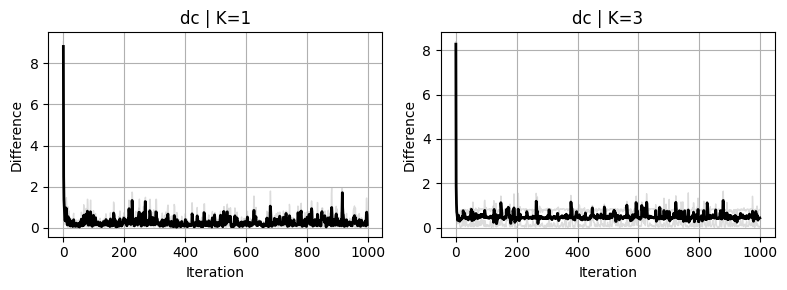

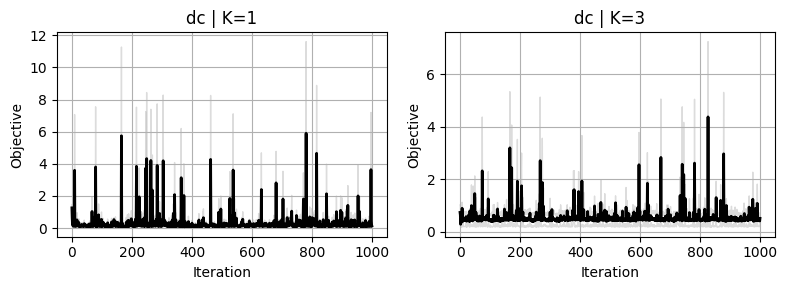

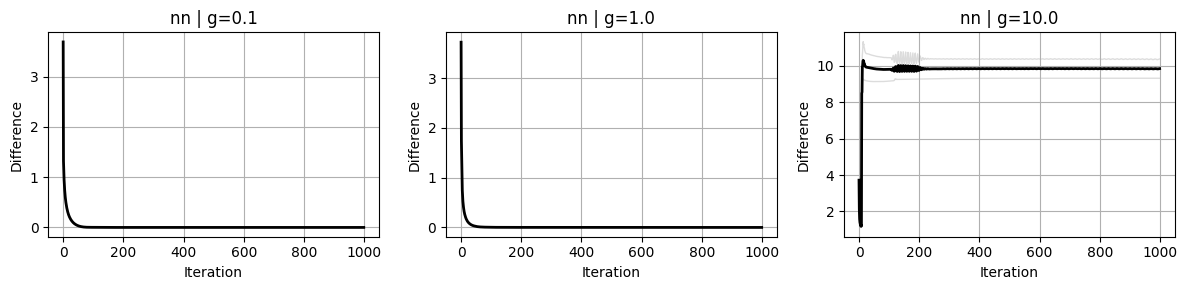

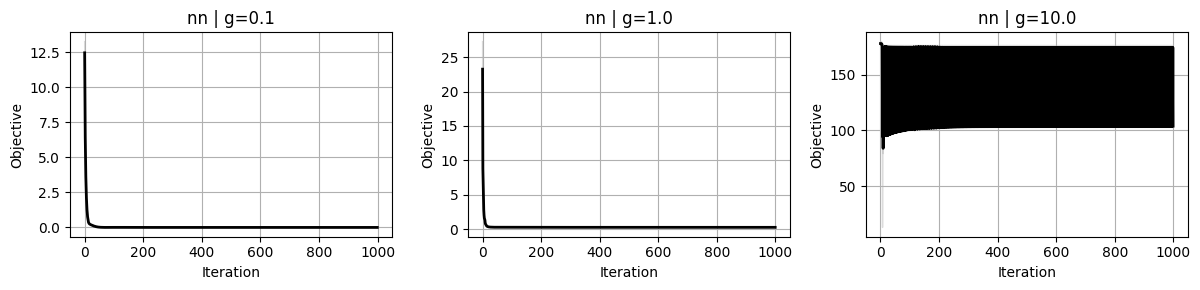

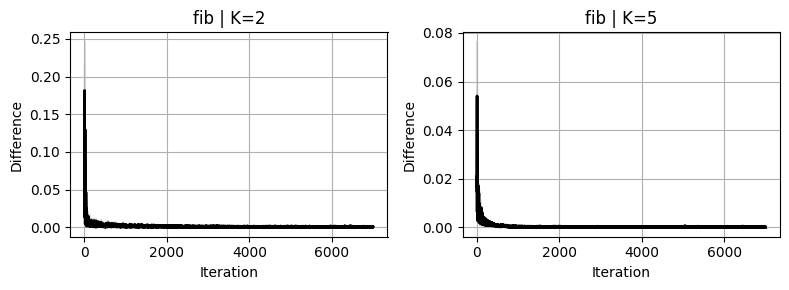

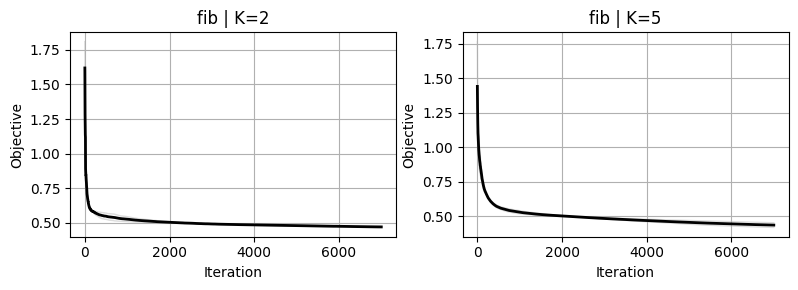

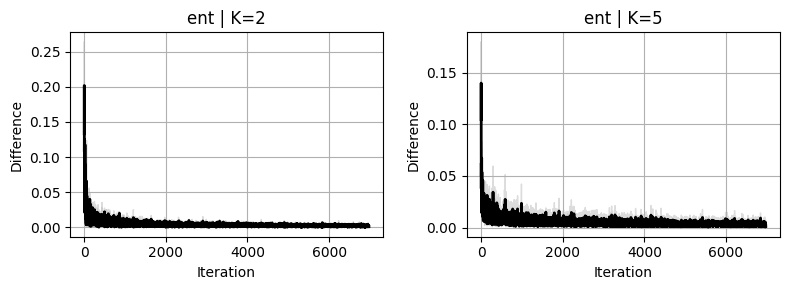

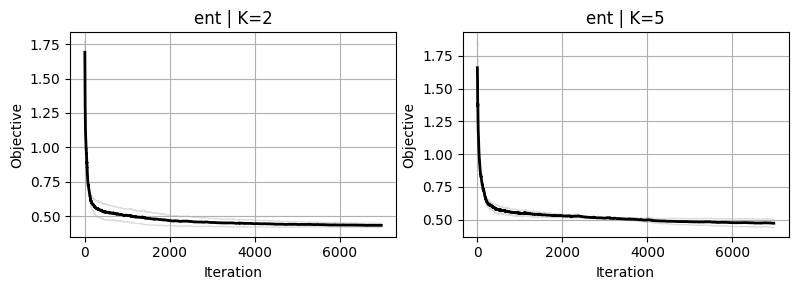

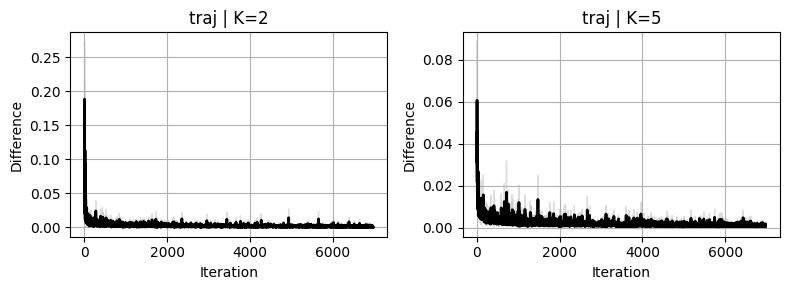

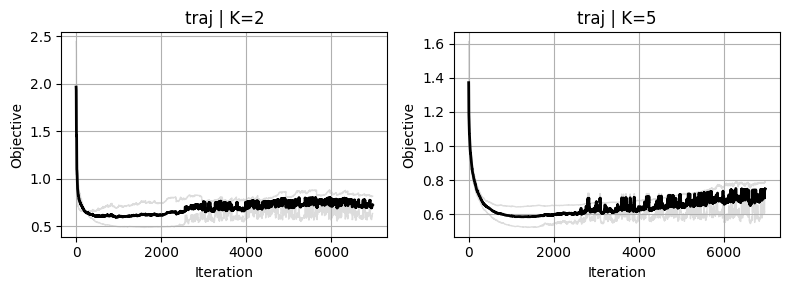

In [15]:
clrs = dict(zip( method_names, list(bright_qual.values())+list(vib_qual.values()) ))
diffs_mean = dict(zip(method_names,[None]*len(method_names)))
costs_mean = dict(zip(method_names,[None]*len(method_names)))

for n in method_names:
    if n=="sm":
        continue
    diffs_mean[n] = [np.mean( list(map( lambda diffs: diffs + [0]*(max(list(map( len,diffs_est[n][i] )))-len(diffs)), diffs_est[n][i] )), axis=0 ) for i in range(len(method_args[n]))]
    costs_mean[n] = [np.mean( list(map( lambda costs: costs + [0]*(max(list(map( len,costs_est[n][i] )))-len(costs)), costs_est[n][i] )), axis=0 ) for i in range(len(method_args[n]))]

    fig = plt.figure(figsize=(len(method_args[n])*4,3)); ax = fig.subplots(1,len(method_args[n])); _ = [a.grid(1) for a in ax]
    for i in range(len(method_args[n])):
        a = ax[i]
        _ = [a.plot( diffs_est[n][i][t], '-', linewidth=1, c='#bbbbbb', zorder=1, alpha=.5 ) for t in range(trials)]
        a.plot( diffs_mean[n][i], '-', linewidth=2, c='k', zorder=3 )
        a.set_xlabel("Iteration")
        a.set_ylabel("Difference")
        a.set_title(n + " | " + method_msgs[n][i])
    fig.tight_layout()

    fig = plt.figure(figsize=(len(method_args[n])*4,3)); ax = fig.subplots(1,len(method_args[n])); _ = [a.grid(1) for a in ax]
    for i in range(len(method_args[n])):
        a = ax[i]
        _ = [a.plot( costs_est[n][i][t], '-', linewidth=1, c='#bbbbbb', zorder=1, alpha=.5 ) for t in range(trials)]
        a.plot( costs_mean[n][i], '-', linewidth=2, c='k', zorder=3 )
        a.set_xlabel("Iteration")
        a.set_ylabel("Objective")
        a.set_title(n + " | " + method_msgs[n][i])
    fig.tight_layout()


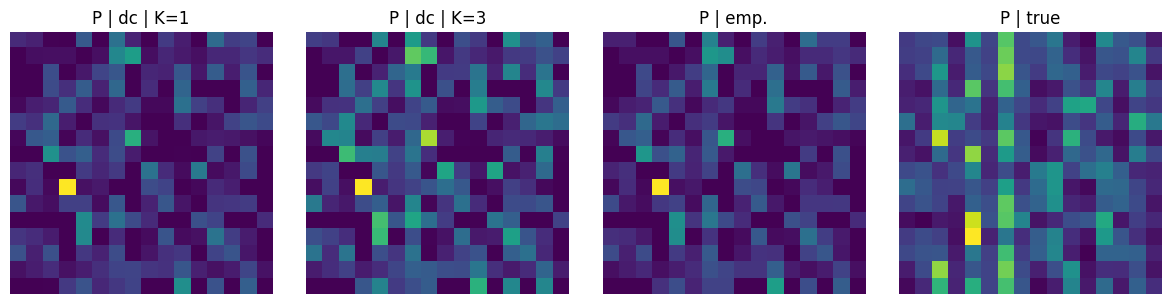

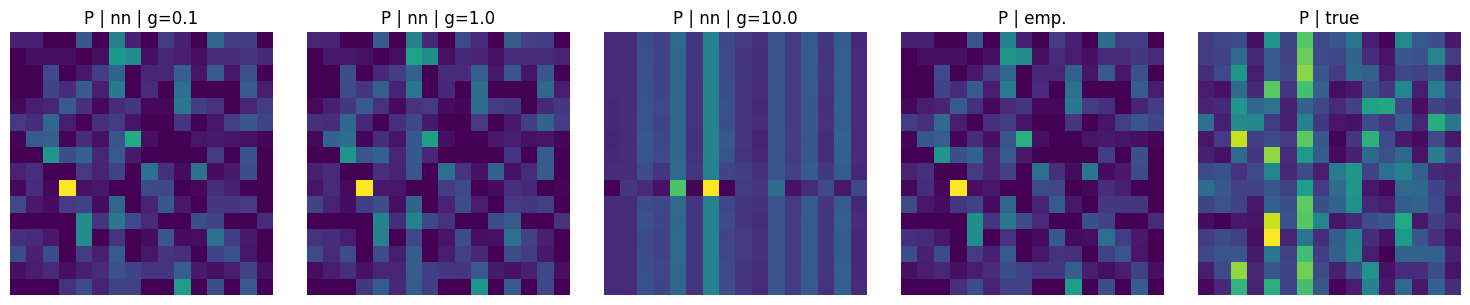

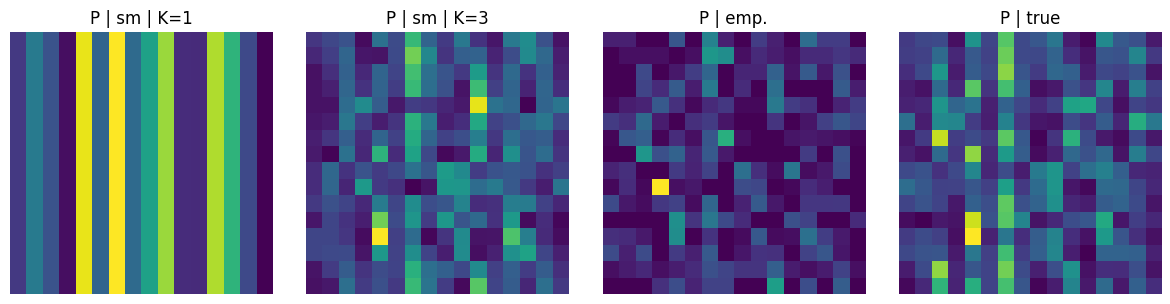

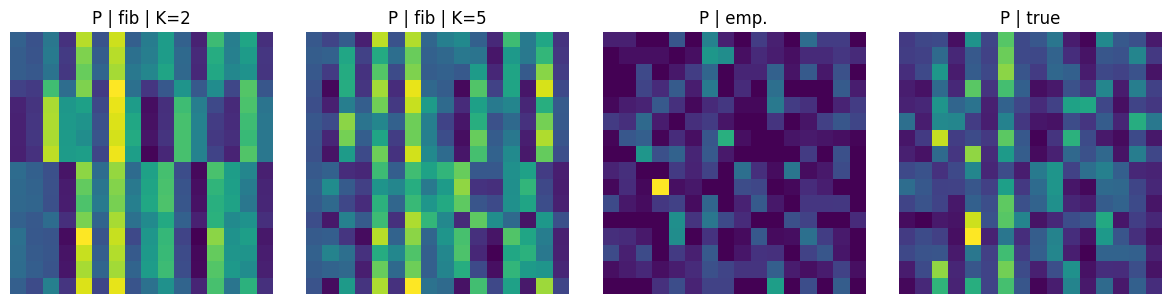

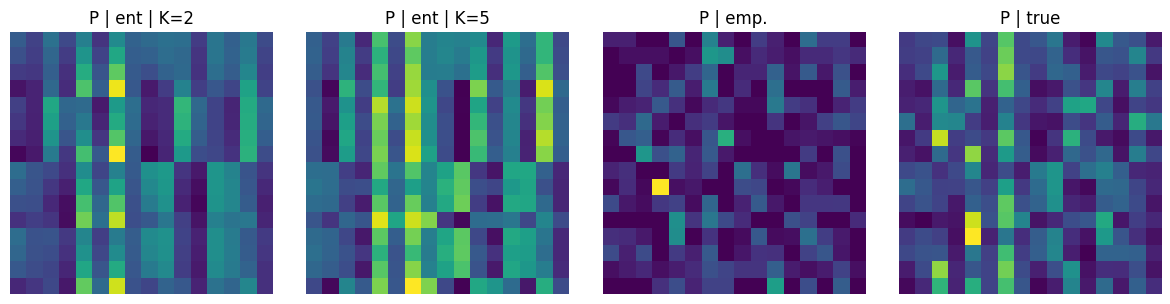

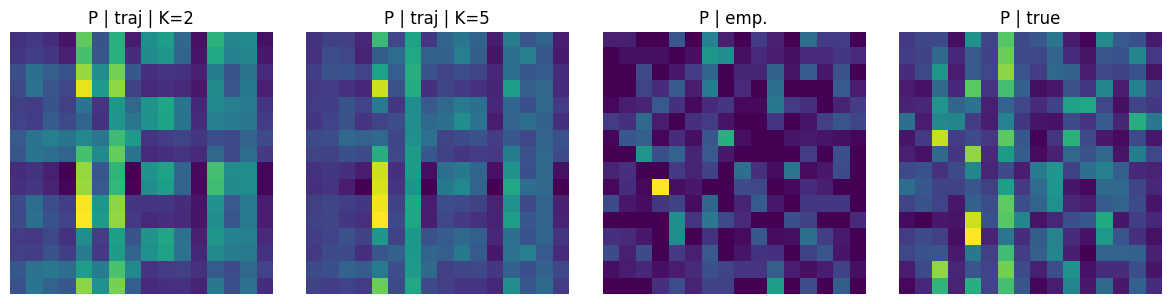

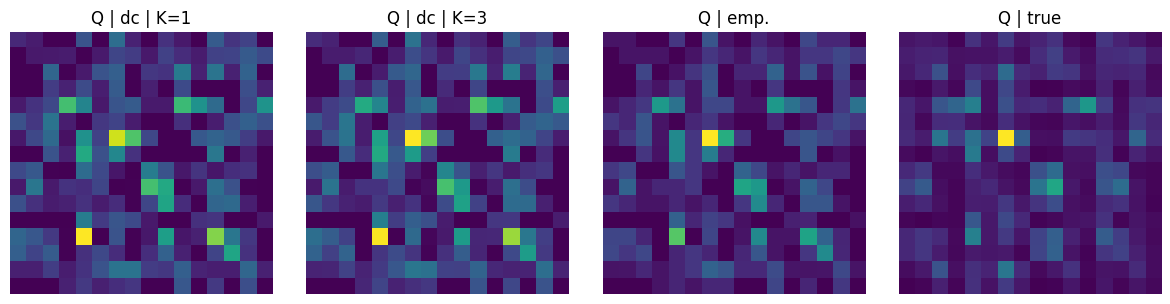

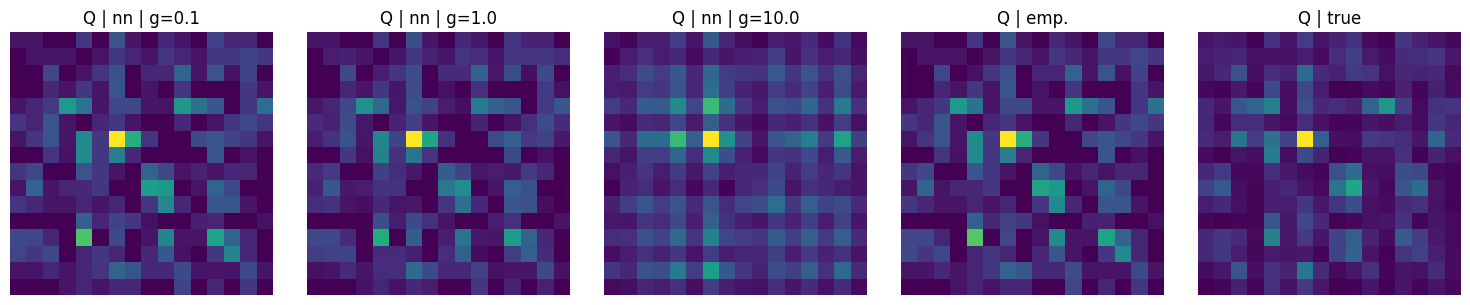

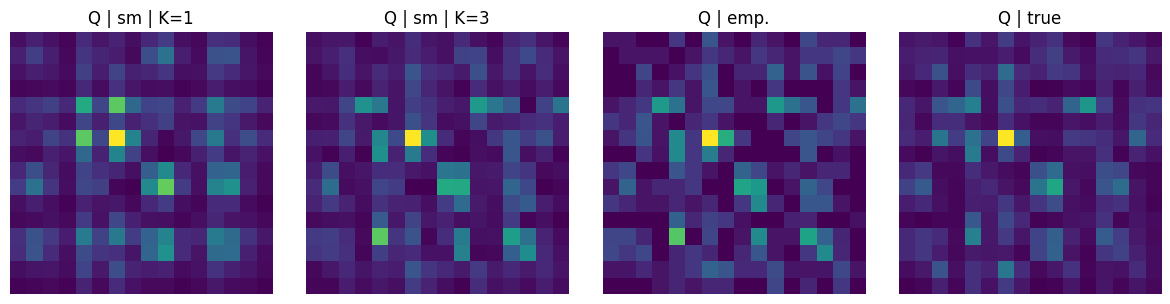

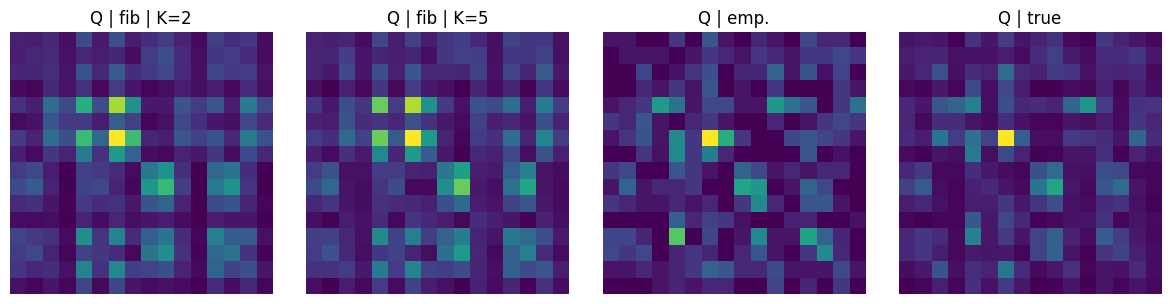

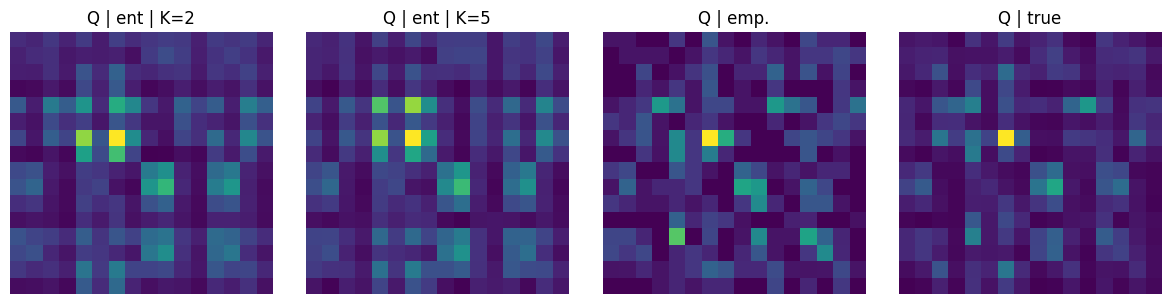

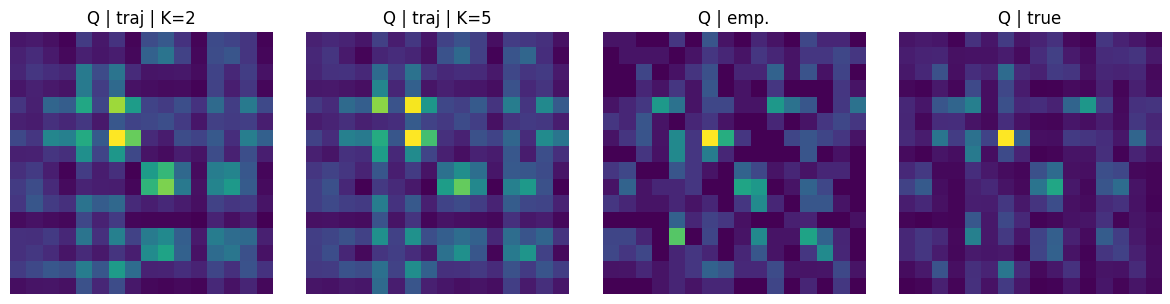

In [16]:
P_mean = torch.stack([mc[t].P for t in range(trials)]).mean(0)
P_emp_mean = torch.stack([mc_emp[t].P for t in range(trials)]).mean(0)
P_est_mean = {n:[torch.stack([mc_est[n][i][t].P for t in range(trials)]).mean(0) for i in range(len(method_args[n]))] for n in method_names}

for n in method_names:
    fig = plt.figure(figsize=((len(method_args[n])+2)*3,3)); ax = fig.subplots(1,len(method_args[n])+2); _ = [a.axis('off') for a in ax]
    for i in range(len(method_args[n])):
        a = ax[i]
        a.imshow( P_est_mean[n][i] )
        a.set_title("P | " + n + " | " + method_msgs[n][i])
    a = ax[-2]
    a.imshow( P_emp_mean )
    a.set_title("P | emp.")
    a = ax[-1]
    a.imshow( P_mean )
    a.set_title("P | true")
    fig.tight_layout()

Q_mean = torch.stack([mc[t].Q for t in range(trials)]).mean(0)
Q_emp_mean = torch.stack([mc_emp[t].Q for t in range(trials)]).mean(0)
Q_est_mean = {n:[torch.stack([mc_est[n][i][t].Q for t in range(trials)]).mean(0) for i in range(len(method_args[n]))] for n in method_names}

for n in method_names:
    fig = plt.figure(figsize=((len(method_args[n])+2)*3,3)); ax = fig.subplots(1,len(method_args[n])+2); _ = [a.axis('off') for a in ax]
    for i in range(len(method_args[n])):
        a = ax[i]
        a.imshow( Q_est_mean[n][i] )
        a.set_title("Q | " + n + " | " + method_msgs[n][i])
    a = ax[-2]
    a.imshow( Q_emp_mean )
    a.set_title("Q | emp.")
    a = ax[-1]
    a.imshow( Q_mean )
    a.set_title("Q | true")
    fig.tight_layout()


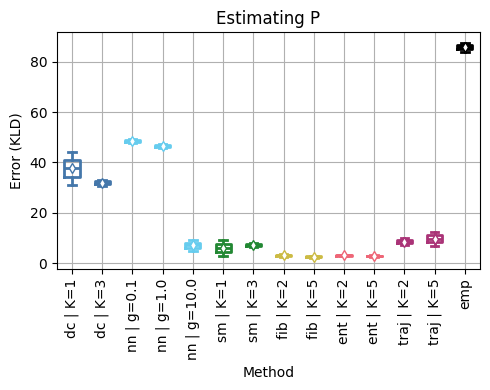

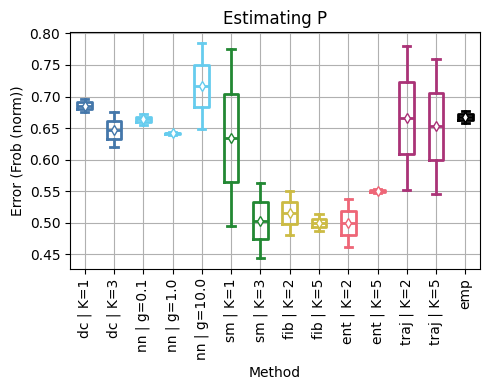

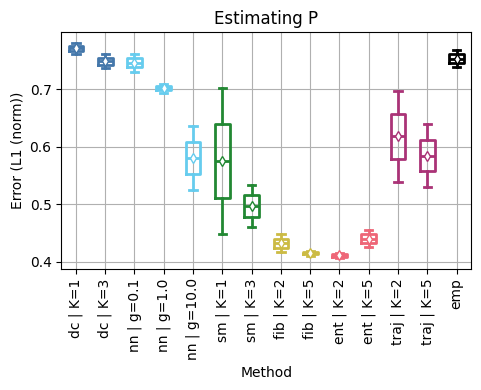

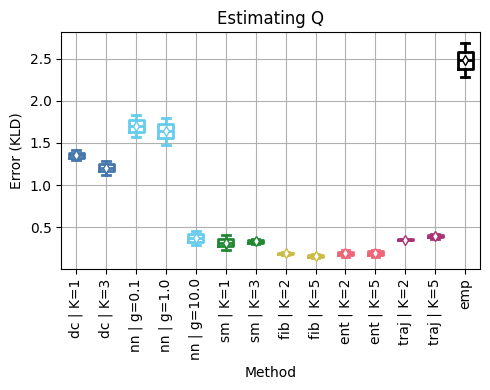

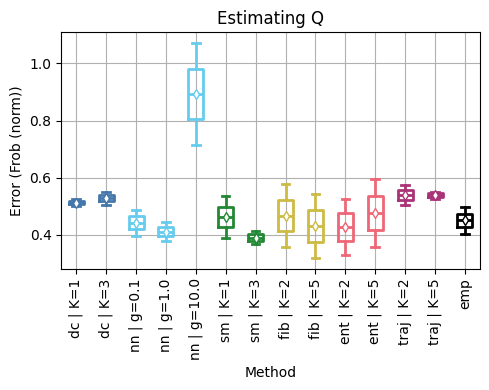

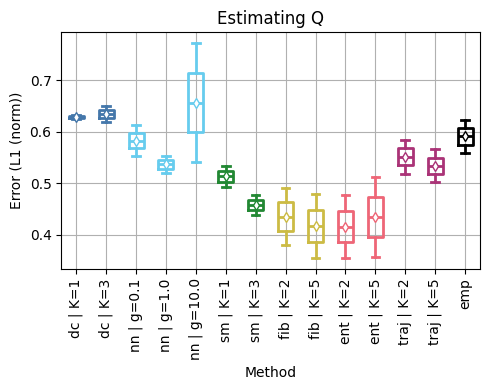

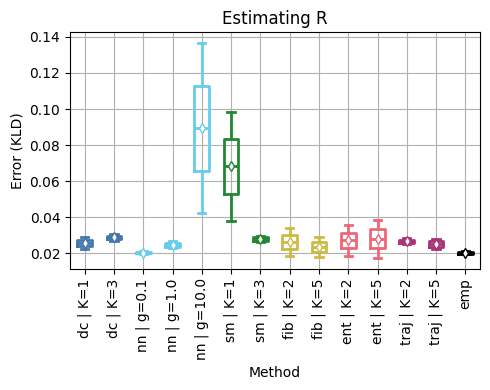

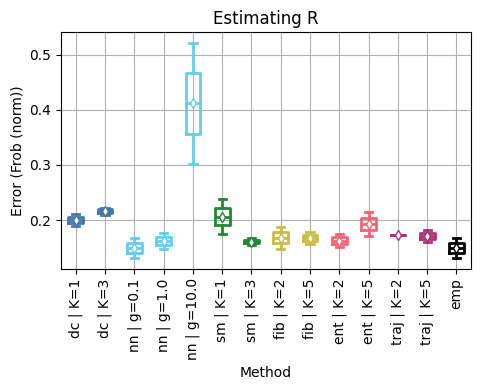

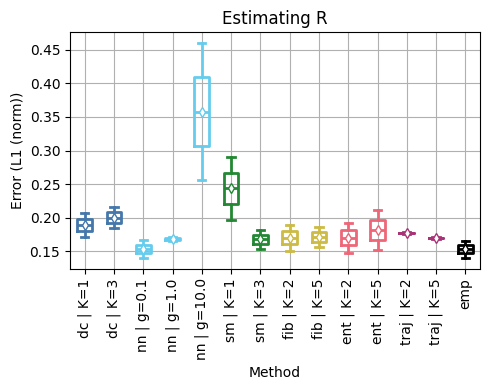

In [20]:
boxprops = [dict(linewidth=2, color=clrs[n]) for n in method_names for i in range(len(method_args[n]))]
flierprops = [dict(linewidth=1, markeredgecolor=clrs[n], markerfacecolor=clrs[n]) for n in method_names for i in range(len(method_args[n]))]
medianprops = [dict(linewidth=3,color=clrs[n]) for n in method_names for i in range(len(method_args[n]))]
bp_clrs = [clrs[n] for n in method_names for i in range(len(method_args[n]))] + ['k']

kld_P = {n:[torch.FloatTensor([kld_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)]) for i in range(len(method_args[n]))] for n in method_names}
kld_P['emp'] = torch.FloatTensor([kld_err(mc[t].P,laplace_smoothing(mc_emp[t].P,N,1e-7)) for t in range(trials)])
kld_Q = {n:[torch.FloatTensor([kld_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)]) for i in range(len(method_args[n]))] for n in method_names}
kld_Q['emp'] = torch.FloatTensor([kld_err(mc[t].Q,laplace_smoothing(mc_emp[t].Q,N,1e-7)) for t in range(trials)])
kld_R = {n:[torch.FloatTensor([kld_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)]) for i in range(len(method_args[n]))] for n in method_names}
kld_R['emp'] = torch.FloatTensor([kld_err(mc[t].R,laplace_smoothing(mc_emp[t].R,N,1e-7)) for t in range(trials)])

normfrob_P = {n:[torch.FloatTensor([normfrob_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)]) for i in range(len(method_args[n]))] for n in method_names}
normfrob_P['emp'] = torch.FloatTensor([normfrob_err(mc[t].P,laplace_smoothing(mc_emp[t].P,N,1e-7)) for t in range(trials)])
normfrob_Q = {n:[torch.FloatTensor([normfrob_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)]) for i in range(len(method_args[n]))] for n in method_names}
normfrob_Q['emp'] = torch.FloatTensor([normfrob_err(mc[t].Q,laplace_smoothing(mc_emp[t].Q,N,1e-7)) for t in range(trials)])
normfrob_R = {n:[torch.FloatTensor([normfrob_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)]) for i in range(len(method_args[n]))] for n in method_names}
normfrob_R['emp'] = torch.FloatTensor([normfrob_err(mc[t].R,laplace_smoothing(mc_emp[t].R,N,1e-7)) for t in range(trials)])

norml1_P = {n:[torch.FloatTensor([norml1_err(mc[t].P,mc_est[n][i][t].P) for t in range(trials)]) for i in range(len(method_args[n]))] for n in method_names}
norml1_P['emp'] = torch.FloatTensor([norml1_err(mc[t].P,laplace_smoothing(mc_emp[t].P,N,1e-7)) for t in range(trials)])
norml1_Q = {n:[torch.FloatTensor([norml1_err(mc[t].Q,mc_est[n][i][t].Q) for t in range(trials)]) for i in range(len(method_args[n]))] for n in method_names}
norml1_Q['emp'] = torch.FloatTensor([norml1_err(mc[t].Q,laplace_smoothing(mc_emp[t].Q,N,1e-7)) for t in range(trials)])
norml1_R = {n:[torch.FloatTensor([norml1_err(mc[t].R,mc_est[n][i][t].R) for t in range(trials)]) for i in range(len(method_args[n]))] for n in method_names}
norml1_R['emp'] = torch.FloatTensor([norml1_err(mc[t].R,laplace_smoothing(mc_emp[t].R,N,1e-7)) for t in range(trials)])

method_labs = sum([[f"{n} | {method_msgs[n][i]}" for i in range(len(method_args[n]))] for n in method_names],[]) + ['emp']

title_labs = ["P","Q","R"]
y_labs = ["KLD","Frob (norm)","L1 (norm)"]

errors_all = {
    "P":dict(zip( y_labs, [kld_P, normfrob_P, norml1_P] )),
    "Q":dict(zip( y_labs, [kld_Q, normfrob_Q, norml1_Q] )),
    "R":dict(zip( y_labs, [kld_R, normfrob_R, norml1_R] )),
}

for title in title_labs:
    for y_lab in y_labs:
        errors = errors_all[title][y_lab]
        error = dict(zip(method_labs, [errors[n][i] for n in method_names for i in range(len(method_args[n]))] + [errors['emp']] ))

        fig = plt.figure(figsize=(5,4)); ax = fig.subplots(); ax.grid(1)
        bp = ax.boxplot( error.values(), showmeans=True )
        _ = ax.set_xticks(np.arange(len(error))+1, labels=error.keys(), rotation=90 )
        ax.set_xlabel("Method"); ax.set_ylabel(f"Error ({y_lab})"); ax.set_title(f"Estimating {title}")
        # ax.set_ylim([0,1])

        for elem in ['whiskers','caps']:
            for i,item in enumerate(bp[elem]):
                item.set_linewidth(2)
                item.set_color(bp_clrs[int(i/2)])
        for elem in ['boxes','medians']:
            for i,item in enumerate(bp[elem]):
                item.set_linewidth(2)
                item.set_color(bp_clrs[i])
        for i,item in enumerate(bp['fliers']):
            item.set_linewidth(.5)
            item.set_marker('o')
            item.set_markersize(5)
            item.set_markeredgecolor(bp_clrs[i])
        for i,item in enumerate(bp['means']):
            item.set_linewidth(.5)
            item.set_marker('d')
            item.set_markersize(5)
            item.set_markeredgecolor(bp_clrs[i])
            item.set_markerfacecolor('w')

        fig.tight_layout()


In [19]:
if SAVE_RESULTS:
    if not os.path.exists(folder):
        os.mkdir(folder)

    results_dict = dict( mc_est=mc_est,
        diffs_est=diffs_est,
        costs_est=costs_est,
        K_ten_range=K_ten_range,
        K_mat_range=K_mat_range,
        gamma_range=gamma_range,
        ipdc_args=ipdc_args,
        sgsadmm_args=sgsadmm_args,
        slrm_args=slrm_args,
        scpdfib_args=scpdfib_args,
        scpdent_args=scpdent_args,
        scpdtraj_args=scpdtraj_args,
    )

    results_path = os.path.join(folder,results_file)
    with open(results_path,"wb") as f:
        pkl.dump(results_dict,f)
        print(f"Results have been saved to {results_path}")
if LOAD_RESULTS:
    results_path = os.path.join(folder,results_file)
    assert os.path.exists(results_path), f"Results file {results_path} does not exist."    
    with open(results_path,"rb") as f:
        loaded_results = pkl.load(f)
        print(f"Results have been loaded from {results_path}.")

    mc_est = loaded_results['mc_est']
    costs_est = loaded_results['costs_est']
    diffs_est = loaded_results['diffs_est']
    K_ten_range = loaded_results['K_ten_range']
    K_mat_range = loaded_results['K_mat_range']
    gamma_range = loaded_results['gamma_range']
    ipdc_args = loaded_results['ipdc_args']
    sgsadmm_args = loaded_results['sgsadmm_args']
    slrm_args = loaded_results['slrm_args']
    scpdfib_args = loaded_results['scpdfib_args']
    scpdent_args = loaded_results['scpdent_args']
    scpdtraj_args = loaded_results['scpdtraj_args']



Results have been saved to synth_comparison/results_2025-05-24-1900
